In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from model.dataset import HSEDataset
from torch.utils.data import DataLoader

from model.regressCNN import RegressionPCA
from SMPL.smpl_torch_batch import SMPLModel

from obj_utils.io import *
from obj_utils.pca import *

In [2]:
cuda_available = torch.cuda.is_available()
print('cuda available:', cuda_available)

device = torch.device('cuda:0' if cuda_available else 'cpu')
print('using device', device)

cuda available: True
using device cuda:0


# Inference on Test Set

In [3]:
infer_model_name = 'checkpoint_Sat_Jun_17_14:41:55_2023'
infer_model_path = f'./checkpoints/{infer_model_name}/male_1000.ckpt'

infer_model = RegressionPCA(10).to(device)
infer_model.load_state_dict(torch.load(infer_model_path))
infer_model.eval()
print('model loaded')

model loaded


In [4]:
test_path = './dataset_HSE/SMPL_augmentated_pose_variation/sample_points/test'

test_dataset = HSEDataset(test_path)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

loading data: 100%|██████████| 7541/7541 [00:07<00:00, 944.56it/s]


In [5]:
def infer(frontal, lateral):
    with torch.no_grad():
        result = infer_model(frontal, lateral)
    
    return result

In [6]:
smpl_model_path = './SMPL/model.pkl'
smpl_model = SMPLModel(device=torch.device('cuda'), model_path=smpl_model_path)

 Tensor J_regressor shape:  torch.Size([24, 6890])
 Tensor joint_regressor shape:  torch.Size([24, 6890])
 Tensor weights shape:  torch.Size([6890, 24])
 Tensor posedirs shape:  torch.Size([6890, 3, 207])
 Tensor v_template shape:  torch.Size([6890, 3])
 Tensor shapedirs shape:  torch.Size([6890, 3, 10])


In [7]:
name_list = []
beta_out_list = []
beta_gt_list = []

for data in tqdm(test_dataloader):
    names, f, l, s = data
    name_list.extend(names)
    beta_gt_list.extend(s)

    f = f.to(device, dtype=torch.float)
    l = l.to(device, dtype=torch.float)
    result = infer(f, l)
    result = np.array(result.to('cpu'))
    beta_out_list.extend(result)

beta_out = np.vstack(beta_out_list)
beta_gt = np.vstack(beta_gt_list)
print(beta_out.shape, beta_gt.shape)

100%|██████████| 15/15 [00:02<00:00,  5.30it/s]

(7541, 10) (7541, 10)


In [8]:
def get_A_pose_parameter(size, pose_variant=False):
    """
    Returns 'A-pose' SMPL pose paramters sized size

    Arguments:
        - size
        - pose_variant (optional)

    Return:
        - poses
    """
    poses = np.zeros((size, 72))
    
    left_arm_noise = np.radians(np.random.uniform(-5, 5, size)) if pose_variant else 0
    right_arm_noise = np.radians(np.random.uniform(-5, 5, size)) if pose_variant else 0

    poses[:,16 *3 + 2] = - np.pi / 3 + left_arm_noise # Left arm 
    poses[:,17 *3 + 2] = np.pi / 3 + right_arm_noise # Right arm

    left_leg_noise = np.radians(np.random.uniform(-3, 3, size)) if pose_variant else 0
    right_leg_noise = np.radians(np.random.uniform(-3, 3, size)) if pose_variant else 0

    poses[:,1 *3 + 2] = +np.pi / 36 + left_leg_noise # Left leg
    poses[:,2 *3 + 2] = -np.pi / 36 + right_leg_noise # Right leg

    poses[:,10 *3 + 2] = -np.pi / 6 - left_leg_noise # Left foot
    poses[:,11 *3 + 2] = +np.pi / 6 - right_leg_noise # Right foot

    return poses

In [9]:
beta_out = torch.from_numpy(beta_out).type(torch.float64).to(device)
beta_gt = torch.from_numpy(beta_gt).type(torch.float64).to(device)

pose = torch.from_numpy(get_A_pose_parameter(beta_out.shape[0])).type(torch.float64).to(device)
trans = torch.from_numpy(np.zeros((beta_out.shape[0], 3))).type(torch.float64).to(device)

In [10]:
batch_size = 512
num_batch = len(beta_out) // 512

v_outs = None
v_gts = None

for i in range(num_batch):
    if i < num_batch-1:
        b_out, p, t = beta_out[i*batch_size:(i+1)*batch_size], pose[i*batch_size:(i+1)*batch_size], trans[i*batch_size:(i+1)*batch_size]
        b_gt = beta_gt[i*batch_size:(i+1)*batch_size]
    else:
        b_out, p, t = beta_out[i*batch_size:], pose[i*batch_size:], trans[i*batch_size:]
        b_gt = beta_gt[i*batch_size:]
    
    v_out, _ = smpl_model(b_out, p, t)
    v_gt, _ = smpl_model(b_gt, p, t)

    if v_outs is None:
        v_outs = np.array(v_out.cpu())
        v_gts = np.array(v_gt.cpu())
    else:
        v_outs = np.concatenate([v_outs, v_out.cpu()])
        v_gts = np.concatenate([v_gts, v_gt.cpu()])

print(v_outs.shape, v_gts.shape)

(7541, 6890, 3) (7541, 6890, 3)


# Save Merged Mesh

In [11]:
from obj_utils.misc import *

In [12]:
results_path = f'./test_results/{infer_model_name}'
os.makedirs(results_path, exist_ok=True)

for i, name in enumerate(tqdm(name_list[:10])):
    v_out, v_gt = v_outs[i], v_gts[i]

    v_out_colored = add_vertices_color(v_out, [1., 0., 0.,])
    v_gt_colored = add_vertices_color(v_gt, [0., 1., 0.,])

    v_merged = merge_vertices(v_out_colored, v_gt_colored)
    save_obj(os.path.join(results_path, f'{name}_merged.obj'), v_merged)

100%|██████████| 10/10 [00:00<00:00, 17.43it/s]


# Calculate V2V

In [13]:
displacement = v_outs - v_gts
distance = np.linalg.norm(displacement, axis=2)
v2v = distance.mean(axis=1) * 1000

mean, std = 0.979 mm, 0.294 mm
min, max = 0.202 mm, 3.888 mm


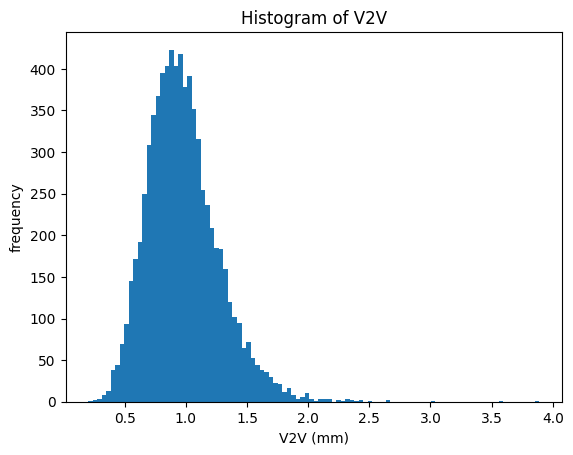

In [14]:
print(f'mean, std = {v2v.mean():.3f} mm, {v2v.std():.3f} mm')
print(f'min, max = {v2v.min():.3f} mm, {v2v.max():.3f} mm')

hist, bins = np.histogram(v2v, bins=100)

plt.title('Histogram of V2V')
plt.xlabel('V2V (mm)')
plt.ylabel('frequency')

plt.hist(bins[:-1], bins, weights=hist)
plt.show()